In [1]:
import requests
import shutil
import os
import time
import math
import json
from tqdm import tqdm
from glob import glob
import random
from PIL import Image
import imghdr
# Multiprocessing stuff
import multiprocessing as mp
NUM_CORES = min(mp.cpu_count(), 50)

# Some CV/DL module
import numpy as np
np.__version__
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Please install GPU version of TF


In [4]:
import time
# Some hyper-parameters
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = './data'
width=256
height=256
depth=3


timestr = time.strftime("%Y%m%d-%H%M%S")
DATASET_CSV = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/data.csv"
DATASET_PATH = org_img_dir = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/20220616-061434/"	# "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/drago_testdata/"
craft_res_dir = org_img_dir.replace('/scraped-data/', '/CRAFT-results/')
seg_img_dir = org_img_dir.replace('/scraped-data/', '/seg-results/')


Note: There are 7,982,741 images avaialble in GBIF database, but we only scrapped 1198 images for evaluation purpose. If you want to see the amount of data that we have, use the following code, or you can checkout the 'scraping' folder to scrape more data from the website.

```python
# If you want to read the data from that data.csv file
import pandas as pd
df = pd.read_csv(DATASET_PATH + DATASET_CSV, sep="\t")
DATASET_TYPE = "csv"
colnames = []
for col in df.columns:
    colnames.append(col)
print(f"colnames: {colnames}")
print(f"df.shape: {df.shape}")
```



In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv(DATASET_CSV, sep="\t")
DATASET_TYPE = "csv"
colnames = []
for col in df.columns:
    colnames.append(col)
print(f"colnames: {colnames}")
print(f"df.shape: {df.shape}")

/share/pkg.7/python3/3.8.10/install/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (2,14,16,17,19,21,24,25,26,32,33,34,36,37,38,39,40,41,43,45,46) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


colnames: ['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'infraspecificEpithet', 'taxonRank', 'scientificName', 'verbatimScientificName', 'verbatimScientificNameAuthorship', 'countryCode', 'locality', 'stateProvince', 'occurrenceStatus', 'individualCount', 'publishingOrgKey', 'decimalLatitude', 'decimalLongitude', 'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation', 'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day', 'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord', 'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber', 'identifiedBy', 'dateIdentified', 'license', 'rightsHolder', 'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted', 'mediaType', 'issue']
df.shape: (7982741, 50)


## Taking a look at the data csv

In [24]:
df.head()

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,2417026544,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0027832,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Eriophorum,Eriophorum angustifolium,...,Syreyschikov D.,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Syreyschikov D. | Smirnov P.,NaN,NaN,2022-03-25T12:48:46.119Z,StillImage,DIFFERENT_OWNER_INSTITUTION
1,2417026527,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0027833,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Eriophorum,Eriophorum angustifolium,...,Syreyschikov D.,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Syreyschikov D. | Smirnov P.,NaN,NaN,2022-03-25T12:48:46.120Z,StillImage,DIFFERENT_OWNER_INSTITUTION
2,2458329530,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0003877,Plantae,Tracheophyta,Liliopsida,Alismatales,Hydrocharitaceae,Elodea,Elodea canadensis,...,Identified by the collector,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,S.S. Ganeshin,NaN,NaN,2022-03-25T12:48:46.136Z,StillImage,DIFFERENT_OWNER_INSTITUTION
3,2417025838,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0027817,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Eriophorum,Eriophorum angustifolium,...,Syreyschikov D.,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Syreyschikov D. | Smirnov P.,NaN,NaN,2022-03-25T12:48:46.142Z,StillImage,DIFFERENT_OWNER_INSTITUTION
4,2458328836,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0003842,Plantae,Tracheophyta,Liliopsida,Alismatales,Butomaceae,Butomus,Butomus umbellatus,...,Chernyakovskaya-Reyneke,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Chernyakovskaya-Reyneke,NaN,NaN,2022-03-25T12:48:46.168Z,StillImage,DIFFERENT_OWNER_INSTITUTION


In [ ]:
df["elevation"].describe()

count     823719.0
unique      6114.0
top         1524.0
freq       14707.0
Name: elevation, dtype: float64

In [26]:
df.info

<bound method DataFrame.info of              gbifID                            datasetKey  \
0        2417026544  af5f680a-e0cc-46c8-b623-ceeaab70aa9e   
1        2417026527  af5f680a-e0cc-46c8-b623-ceeaab70aa9e   
2        2458329530  af5f680a-e0cc-46c8-b623-ceeaab70aa9e   
3        2417025838  af5f680a-e0cc-46c8-b623-ceeaab70aa9e   
4        2458328836  af5f680a-e0cc-46c8-b623-ceeaab70aa9e   
...             ...                                   ...   
7982736  2827587077  07a54454-87c7-4e1e-b2ba-88a9d98d534b   
7982737  2828285624  07a54454-87c7-4e1e-b2ba-88a9d98d534b   
7982738  2829949656  07a54454-87c7-4e1e-b2ba-88a9d98d534b   
7982739  2829291115  07a54454-87c7-4e1e-b2ba-88a9d98d534b   
7982740  2827592996  07a54454-87c7-4e1e-b2ba-88a9d98d534b   

                                 occurrenceID  kingdom        phylum  \
0                                  MHA0027832  Plantae  Tracheophyta   
1                                  MHA0027833  Plantae  Tracheophyta   
2                  

## Looking at the most represented genus' in our data (and who collected the species)

In [21]:
x = df['genus'].value_counts()
print(f"We have {len(x)} of genus in total!")
x[:15]

We have 15462 of genus in total!


Carex         228853
Salix          78596
Euphorbia      60624
Juncus         57851
Viola          49885
Poa            47517
Panicum        46575
Solanum        46365
Cyperus        46232
Rubus          45239
Asplenium      44381
Astragalus     44308
Ranunculus     42849
Quercus        35643
Crataegus      34260
Name: genus, dtype: int64

<AxesSubplot:>

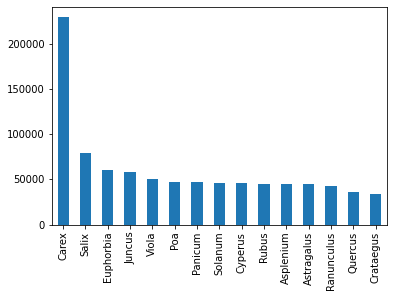

In [10]:
df['genus'].value_counts()[:15].plot(kind='bar',title = "Most Represented Genus")

We have 255793 of genus in total!


<AxesSubplot:>

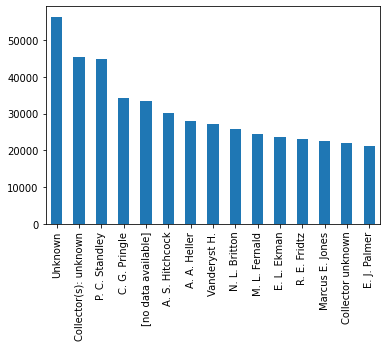

In [22]:
x = df['recordedBy'].value_counts()
print(f"We have {len(x)} of genus in total!")
x[:15].plot(kind='bar',title = "People with most Recorded Species")

count     7820540
unique        250
top            US
freq      2554823
Name: countryCode, dtype: object
We have 250 of genus in total!


<AxesSubplot:>

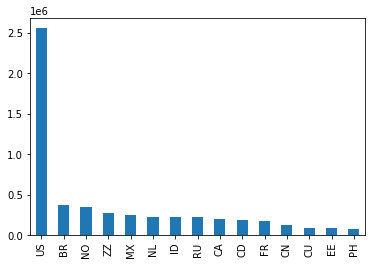

In [32]:
print(df["countryCode"].describe())
x = df['countryCode'].value_counts()
print(f"We have {len(x)} of genus in total!")
x[:15].plot(kind='bar',title = "Most Represented Countries")

<AxesSubplot:ylabel='countryCode'>

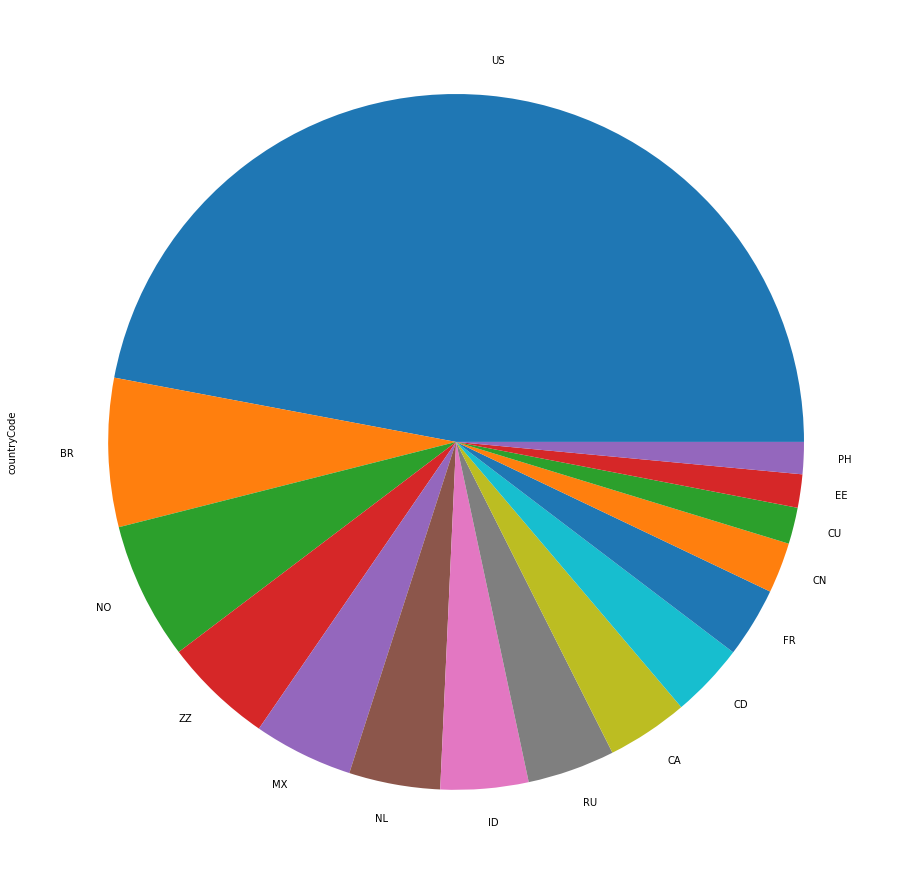

In [40]:
kwargs = dict(

    startangle = 90,
    colormap   = 'Pastel2',
    fontsize   = 13,
    explode    = (0.1,0.1,0.1),
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    title      = 'Chemotherapy Stratification'
)
df['countryCode'].value_counts()[:15].plot.pie(y=df['countryCode'].unique(), figsize=(24, 16),title = "Most Represented Countries")
# df.plot.pie(y='mass', figsize=(5, 5))

## Extract the bounding box that detected by CRAFT

In [4]:
boxes = {}
def addBox(fname):
	if ".jpg" in fname and "mask" not in fname:
		# imgs.append(cv2.imread(os.path.join(craft_res_dir, fname)))
		tmp_txt = open(os.path.join(craft_res_dir, fname[:len(fname)-3]+"txt"),"r").read().split("\n")[:-1]
		tmp_txt = [line.split(",") for line in tmp_txt]
		tmp_bxs = [[[int(line[i]),int(line[i+1])] for i,val in enumerate(line) if int(i)%2==0] for line in tmp_txt ]
		boxes[fname[4:len(fname)-4]] = tmp_bxs
		return boxes
def fillBoxes():
	print("\nFilling boxes dictionary...")
	print("Starting multiprocessing...")
	list_imgs = sorted(os.listdir(craft_res_dir))
	pool = mp.Pool(NUM_CORES)
	for item in tqdm(pool.imap(addBox, list_imgs), total=len(sorted(os.listdir(craft_res_dir)))):
		if item: boxes.update(item)
	pool.close()
	pool.join()
	print("\nBoxes dictionary filled.\n")
# Get all the bounding boxes that segmented by CRAFT
fillBoxes()
print(f"imgIDs that extracted by CRAFT: {boxes.keys()}")


Filling boxes dictionary...
Starting multiprocessing...


100%|██████████| 90/90 [00:00<00:00, 349.89it/s]


Boxes dictionary filled.

imgIDs that extracted by CRAFT: dict_keys(['1228540653', '1456077691', '1675922214', '1699810828', '1701985163', '1702403767', '1805438386', '1928727829', '1930079276', '1991447360', '1998924583', '1998999444', '1999141230', '1999191965', '1999346883', '2236069168', '2265361450', '2513962787', '2514610251', '2515453969', '2516377361', '2516548361', '2517498948', '2900391670', '3016518613', '3416707636', '436989369', '437989544', '438312026', '574701445'])


## Let's get all the image ids and store them in a dictionary, with imgID as key, and a img numpy arr as value

In [16]:
img_dict = {}	# Dict<int: imgId, nparr: img>

def addImg(fIdx):
	# By default, cv2.imread() use BGR, if you want to read in grayscale use, cv2.imread('image_1.png', 1)
	temp_img = cv2.imread(os.path.join(DATASET_PATH, fIdx+".jpg"))	
	# convert image form BGR to RGB color for matplotlib
	img_dict[fIdx] = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
	return img_dict

def getOrigImgs():
	print("Getting original images...")
	print("Starting multiprocessing...")
	file_list = sorted(os.listdir(DATASET_PATH))
	imgIds_list = [img[:-4] for img in file_list if ".jpg" in img]
	pool = mp.Pool(NUM_CORES)
	for item in tqdm(pool.imap(addImg, imgIds_list), total=len(imgIds_list)):
		img_dict.update(item)
	pool.close()
	pool.join()
	print("\nOriginal images obtained.\n")
getOrigImgs()
img_list = list(img_dict.items())	# a list of Tuple<int: imgId, nparr: img>

Getting original images...
Starting multiprocessing...


100%|██████████| 30/30 [00:05<00:00,  5.07it/s]



Original images obtained.



## Let check the size of each image

In [17]:
def check_img_shape(img_dict):
	# Check image shape for each img item in the img_dict
	shape_list = []
	for key, value in img_dict.items():
		shape_list.append(value.shape)
	print(f"shape_list: {shape_list}")
	return shape_list
print(f"Number of images: {len(img_dict)}")
check_img_shape(img_dict)

Number of images: 30
shape_list: [(2250, 1500, 3), (9101, 6934, 3), (8940, 6771, 3), (1400, 990, 3), (5862, 3411, 3), (5810, 3426, 3), (1144, 1590, 3), (5616, 3744, 3), (5500, 3700, 3), (7100, 4800, 3), (8688, 5792, 3), (8688, 5792, 3), (5616, 3744, 3), (4907, 3399, 3), (8688, 5792, 3), (8955, 6796, 3), (5616, 3744, 3), (1920, 1135, 3), (1920, 1080, 3), (1920, 1169, 3), (1920, 1084, 3), (1920, 1094, 3), (1920, 1188, 3), (9126, 6834, 3), (1600, 1005, 3), (1241, 2000, 3), (5160, 3325, 3), (5110, 3377, 3), (5234, 3281, 3), (1500, 926, 3)]


[(2250, 1500, 3),
 (9101, 6934, 3),
 (8940, 6771, 3),
 (1400, 990, 3),
 (5862, 3411, 3),
 (5810, 3426, 3),
 (1144, 1590, 3),
 (5616, 3744, 3),
 (5500, 3700, 3),
 (7100, 4800, 3),
 (8688, 5792, 3),
 (8688, 5792, 3),
 (5616, 3744, 3),
 (4907, 3399, 3),
 (8688, 5792, 3),
 (8955, 6796, 3),
 (5616, 3744, 3),
 (1920, 1135, 3),
 (1920, 1080, 3),
 (1920, 1169, 3),
 (1920, 1084, 3),
 (1920, 1094, 3),
 (1920, 1188, 3),
 (9126, 6834, 3),
 (1600, 1005, 3),
 (1241, 2000, 3),
 (5160, 3325, 3),
 (5110, 3377, 3),
 (5234, 3281, 3),
 (1500, 926, 3)]

## Let's visualize some sampled images

#### Let's first try out some sample image, and review some OpenCV module first

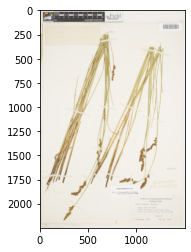

In [20]:
plt.imshow(img_list[0][1]);
# Alternatively, you can use "cv2.imshow('color image',img_color)", but this doesn't allow work for Jupyter Notebook

gray_img: (2250, 1500)


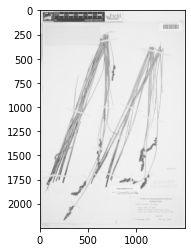

In [21]:
# convert image to grayscale
gray_img = cv2.cvtColor(img_list[0][1], cv2.COLOR_RGB2GRAY)
print(f"gray_img: {gray_img.shape}") # grayscale image represented as a 2-d array

# have to convert grayscale back to RGB for plt.imshow()
plt.imshow(cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB));

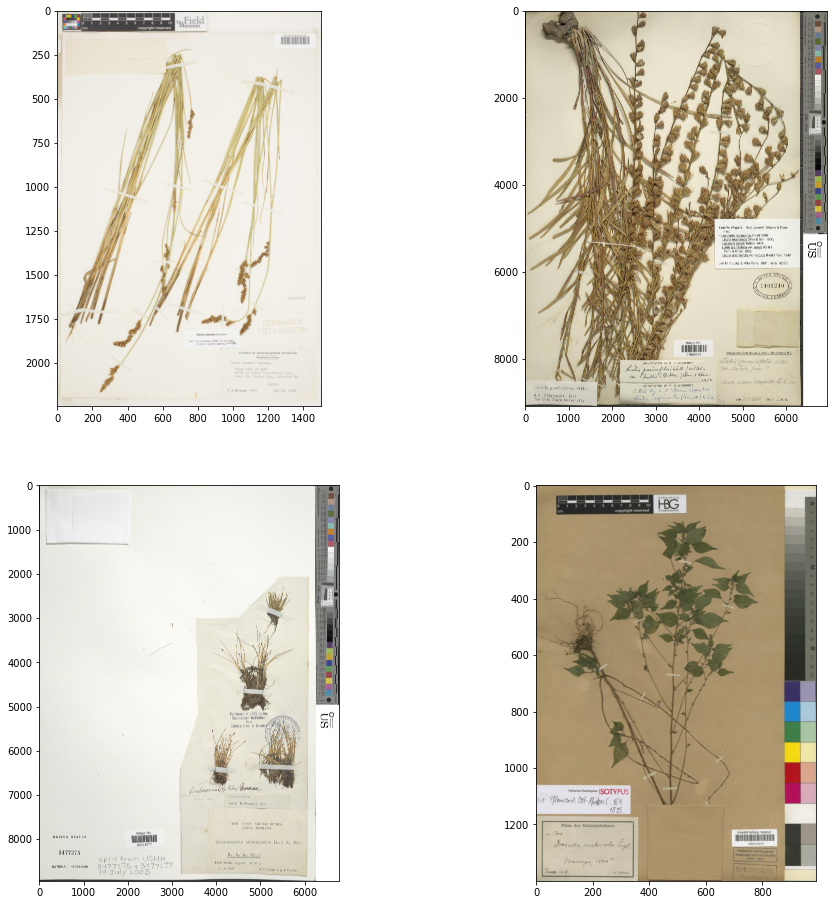

In [26]:
# Visualize the data/images
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
nrow = 2
ncol = 2
# Set up matplotlib figure, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncol*8, nrow*8)
for i in range(nrow*ncol):
    # Moving subplot index(subplot indices start at 1)
    sp = plt.subplot(nrow, ncol, i + 1)
    # sp.axis('Off') # Don't show axes (or gridlines)
    # Display the images
    plt.imshow(img_list[i][1])
# plt.show()

In [ ]:
def main():
	# segment the labels
	fillBoxes()
	getOrigImgs()
	boxes_exp = {key: expand_boxes(bxs, diff_axes=True) for key, bxs in boxes.items()} # expand boxes
	boxes_comb = {key: combine_boxes(bxs) for key, bxs in boxes_exp.items()} # combine the expanded boxes
	boxes_comb_sorted = {key: list(reversed(sort_by_size(bxs)))[0] for key, bxs in boxes_comb.items()} # sort them and take the largest box
	labels = {} # segment label

	for key, image in imgs.items():
		try:
			labels[key]=crop_labels(image, boxes_comb_sorted[key])
		except:
			labels[key]=None
			print("Error cropping label for image: ", key+".jpg")

	# segment the lines of text (used to feed into models like mxnet)
	lines = {key: get_lines(bxs) for key, bxs in boxes.items()}
	lines = {key: expand_boxes(bxs) for key, bxs in lines.items()}
	lines = crop_lines(lines, imgs)

	# save cropped labels
	timestr = time.strftime("%Y%m%d-%H%M%S")

	if os.path.exists(save_dir):
		shutil.rmtree(save_dir)
	os.makedirs(save_dir)

	for key, label in labels.items():
		try:
			plt.imsave(os.path.join(save_dir, key+"_label.jpg"), label)
		except:
			print("Error saving label for image: ", key+".jpg")

	# for i,j in enumerate(lines[0]):
	# 	cv2.imwrite(os.path.join(save_dir, "test"+str(i)+".jpg"), j)

## Looking at the subset of scrapped images we will be using to test our models

In [ ]:
# Getting the country count for our scrapped testing data from gbif
scrapped_images = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/drago_testdata/geography_corpus.txt'
country_count = {}
with open(scrapped_images) as f:
    for line in f:
        line = line.strip()
        if (line in country_count):
            country_count[line] += 1
        else:
            country_count[line] = 1
            
sorted_country = dict(sorted(country_count.items(), key=operator.itemgetter(1),reverse=True))
top_20 = {k: sorted_country[k] for k in list(sorted_country)[:20]}

In [ ]:
#Plotting the top 20 countries for species scans 
plt.bar(top_20.keys(), top_20.values(), width=.4)
plt.xticks(rotation=90)
plt.title('Top 20 Countries of Collection for Scrapped Species Scans');

## Similar to the overall data available from GBIF, the much smaller portion we have scrapped for use testing the models also primarily consists of species scans from the United States. 

In [ ]:
#iam traning data 
iam_path_lines = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/tesseract-training/training/IAM/model_testing/gt/lines'
iam_path_sentences = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/tesseract-training/training/IAM/model_testing/gt/sentences'
iam_path_words = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/tesseract-training/training/IAM/model_testing/gt/words'

line_count = len(glob.glob1(iam_path_lines,"*.png"))
sentence_count = len(glob.glob1(iam_path_sentences,"*.png"))
word_count  = len(glob.glob1(iam_path_words,"*.png"))

print('*** IAM Dataset ***')
print('Total number of line traning examples:',line_count)
print('Total number of sentence traning examples:',sentence_count)
print('Total number of word traning examples:',word_count)

## One of the things we need to keep in mind as we procede with training and testing the Tr-OCR model is that it might prove useful to train the model on all three sets of handwritten text, as well as other printed text examples. Referencing the "What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis" mentioned in our [research markdown](https://github.com/BU-Spark/ml-herbarium/blob/dev/research.md), the authors stressed the importance of ocr models being exposed to a diverse set of handwritten and printed text during training. Doing so may prove to be the most effective way to increase the overall accuracy of the model. Fourtunately, we have an ample amount of data for each different set of training type in handwritten lines, sentences and words. Examples of each of those handwritten samples is shown below.

In [ ]:
# Examples of the training data for lines available in the IAMA dataset
lines = glob.glob1(iam_path_lines,"*.png")
line = random.choice(lines)
line_img = Image.open(iam_path_lines+'/'+line)
f = open(iam_path_lines+'/'+os.path.splitext(line)[0]+'.gt.txt', "r")
print("Ground Truth Label:",f.read())
display(line_img)

# Examples of the training data for sentences available in the IAMA dataset
sentences = glob.glob1(iam_path_sentences,"*.png")
sentence = random.choice(sentences)
sentence_img = Image.open(iam_path_sentences+'/'+sentence)
f = open(iam_path_sentences+'/'+os.path.splitext(sentence)[0]+'.gt.txt', "r")
print("Ground Truth Label:",f.read())
display(sentence_img)

# Examples of the training data for words available in the IAMA dataset
words = glob.glob1(iam_path_words,"*.png")
word = random.choice(words)
word_img = Image.open(iam_path_words+'/'+word)
f = open(iam_path_words+'/'+os.path.splitext(word)[0]+'.gt.txt', "r")
print("Ground Truth Label:",f.read())
display(word_img)

## Another thing we will have to keep in mind is that the model tends to struggle with images that are small, where small can be defined as images less than around 200 kb. From initial testing, the segmentations produced by these small images are unreadable, making the recognition portion of this process nearly impossible. 

In [ ]:
scrapped_images_dir = '/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/drago_testdata/'
# Get list of files in a directory
list_of_files = filter(os.path.isfile,glob.glob(scrapped_images_dir+'*.jpg'))

# Gettting min size of scrapped images (that are valid images)
valid_images = []
for file in list_of_files:
    if imghdr.what(file) == 'jpeg':
        valid_images.append(file)
        
# min and max files from scrapped data
min_file = min(valid_images,key =  lambda file: os.stat(file).st_size)
max_file = max(valid_images,key =  lambda file: os.stat(file).st_size)

print("Smallest file in scraped data (in kb):",os.stat(min_file).st_size/1000)
print("Largest file in scraped data (in kb):",os.stat(max_file).st_size/1000)

In [ ]:
fontsize = 100
plt.figure(figsize=(80, 80))
plt.subplot(1, 2, 1) 
plt.title("Smallest Image Scan",fontdict={'fontsize': fontsize})
plt.imshow(Image.open(min_file),interpolation='nearest');
plt.subplot(1,2,2)
plt.title("Largest Image Scan",fontdict={'fontsize': fontsize})
plt.imshow(Image.open(max_file),interpolation='nearest');

## Clearly, once the text on these images is segmented, it will be incredibly difficult for the model to pull any relevant information from the image on the left (the smallest scrapped image in our test set). This need for larger images is likely do to the training data consisting of fairly clear words. 

In [ ]:
def smallest_file(directory,return_max = False):
    # find the smallest (and largest) png in each of the training datasets
    list_of_files = filter(os.path.isfile,glob.glob(directory+'*.png'))
    
    #Checking image validity
    valid_images = []
    for file in list_of_files:
        if imghdr.what(file) == 'png':
            valid_images.append(file)

    # min from scraped
    min_file = min(valid_images,key =  lambda file: os.stat(file).st_size)
    
    if return_max:
        # max from scraped data
        max_file = max(valid_images,key =  lambda file: os.stat(file).st_size)
        return min_file,max_file
    else:
        return min_file

## Displaying the smallest training examples in the training data from lines, sentences, and words

In [ ]:
#Smallest file in lines
min_file_from_lines = smallest_file(iam_path_lines+'/')
print("Smallest file in lines (in kb):",os.stat(min_file_from_lines).st_size/1000)

#Smallest file in sentences
min_file_from_sentences = smallest_file(iam_path_sentences+'/')
print("Smallest file in sentences (in kb):",os.stat(min_file_from_sentences).st_size/1000)

#Smallest file in words
min_file_from_words = smallest_file(iam_path_words+'/')
print("Smallest file in words (in kb):",os.stat(min_file_from_words).st_size/1000)

In [ ]:
plt.figure(figsize=(20, 10))
plt.suptitle('Smallest Samples from Training Sets');
plt.subplot(1, 3, 1) 
f = open(os.path.splitext(min_file_from_lines)[0]+".gt.txt", "r")
truth = f.read()
plt.title("Ground Truth Label:"+truth)
plt.imshow(Image.open(min_file_from_lines).convert("RGB"),interpolation='nearest');
plt.subplot(1,3,2)
f = open(os.path.splitext(min_file_from_sentences)[0]+".gt.txt", "r")
truth = f.read()
plt.title("Ground Truth Label:"+truth)
plt.imshow(Image.open(min_file_from_sentences).convert("RGB"),interpolation='nearest');
plt.subplot(1,3,3)
f = open(os.path.splitext(min_file_from_words)[0]+".gt.txt", "r")
truth = f.read()
plt.title("Ground Truth Label:"+truth)
plt.imshow(Image.open(min_file_from_words).convert("RGB"));


## For the time being, we will be focusing on the larger images for test purposes. There are possible solutions to this problem, such as super resolution to make the text on the smaller images more readable, but our focus will initially be on dealing with the clearer images. If we are able to get satisfactory results on those scans (which are more represntative of the scans that the Harvard herbarium would have) we can move on to trying to deal with the more pixelated images as a stretch goal. 